In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import shapely
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geopandas import GeoDataFrame
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
import seaborn as sns
from tqdm import tqdm
from pyproj import Geod
geod = Geod(ellps="WGS84")


from shapely import wkt
from tqdm.notebook import tqdm
tqdm.pandas()

from matplotlib import rc, rcParams
rc('font', weight='bold')

In [7]:
a = np.random.rand(4,3);a

array([[0.3516124 , 0.09456073, 0.23907748],
       [0.4200795 , 0.46609321, 0.61633195],
       [0.34968019, 0.67844932, 0.02015142],
       [0.7673431 , 0.73369575, 0.42047993]])

In [63]:
import dask.dataframe as dd
import dask_geopandas
import dask

In [64]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [65]:
south_asia = gpd.GeoDataFrame({'geometry': [Polygon([(70, -25), (50, 80), (150, 80), (150, -25)])]}).set_geometry('geometry')
south_asia.crs = 'EPSG:4326'

In [66]:
south_asia = gpd.sjoin(world, south_asia, predicate = 'within')
south_asia = south_asia[south_asia.name.isin(['Nepal', 'Bangladesh', 'Bhutan', 'China', 'India', 'Maldives', 'Srilanka'])]

<AxesSubplot: >

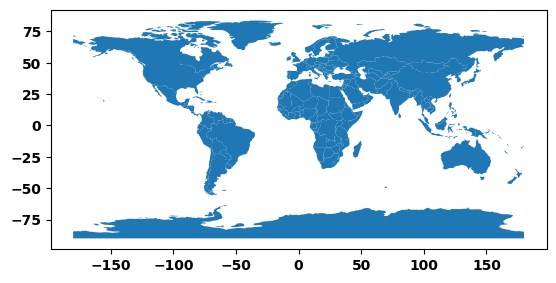

In [67]:
world.plot()

<AxesSubplot: >

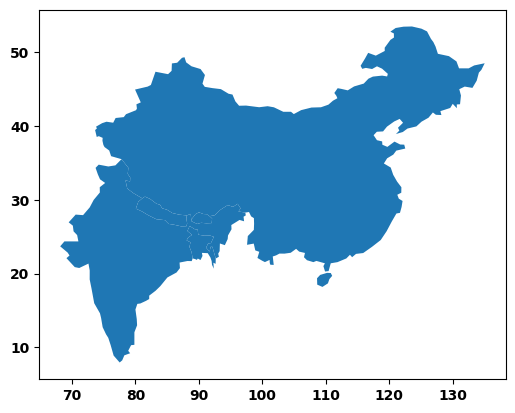

In [68]:
south_asia.plot() # india, china ,nepal, maldives, bangladesh, bhutan, srilank 

In [69]:
df = pd.read_parquet(r"E:\Data\SOUTH_ASIA_OMI_TROPOMI\FILTERED_SOUTH_ASIA_OMI.parquet")

In [70]:
df = df.reset_index(drop = True)

In [71]:
df

,Date,OMI_NO2,Latitude,Longitude,Country
0,200501,1.093671e+15,6.050000,80.350021,Sri Lanka
1,200501,1.226825e+15,6.050000,80.449997,Sri Lanka
2,200501,1.237118e+15,6.050000,80.550003,Sri Lanka
3,200501,1.250257e+15,6.050000,80.650009,Sri Lanka
4,200501,1.112313e+15,6.149999,80.250015,Sri Lanka
...,...,...,...,...,...
28247184,202212,3.301614e+14,28.049999,91.050003,Bhutan
28247185,202212,2.113229e+14,28.149998,89.750015,Bhutan
28247186,202212,1.192334e+14,28.149998,89.850021,Bhutan
28247187,202212,4.526930e+13,28.149998,90.350021,Bhutan


# Filtering data for major cities in South Asia

In [72]:
import osmnx as ox

In [73]:
New_Delhi = ox.geocode_to_gdf('New Delhi, India')[['geometry']] 
Kathmandu = ox.geocode_to_gdf('Kathmandu, Nepal')[['geometry']] 
Dhaka = ox.geocode_to_gdf('Dhaka, Bangladesh')[['geometry']] 
Beijing = ox.geocode_to_gdf('Beijing, China')[['geometry']] 
Islamabad = ox.geocode_to_gdf("Islamabad, Pakistan")[['geometry']]

In [74]:
locations = {'New Delhi':New_Delhi, 'Kathmandu':Kathmandu, "Dhaka": Dhaka, "Beijing": Beijing, "Islamabad":Islamabad}

  0%|          | 0/5 [00:00<?, ?it/s]

CURRENT LOCATION:  New Delhi


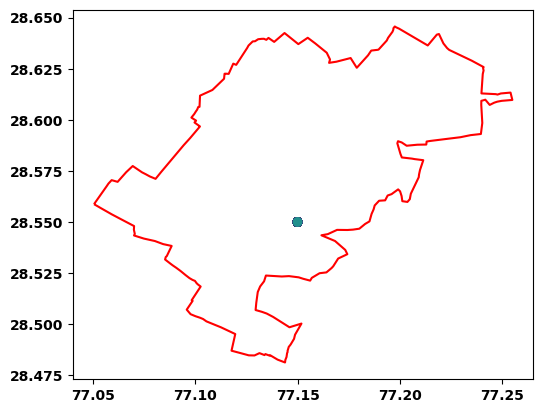

CURRENT LOCATION:  Kathmandu


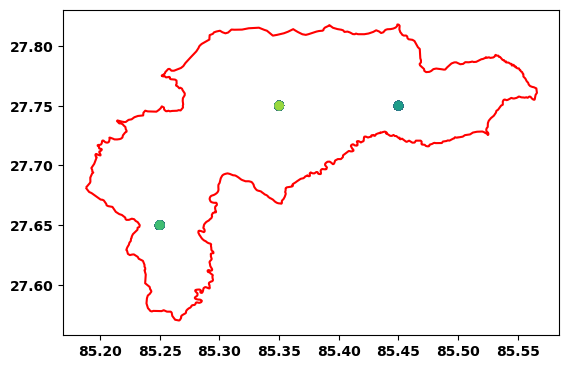

CURRENT LOCATION:  Dhaka


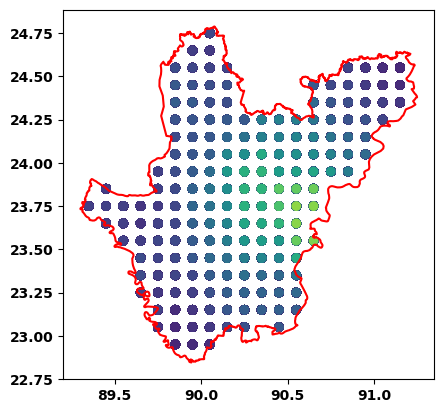

CURRENT LOCATION:  Beijing


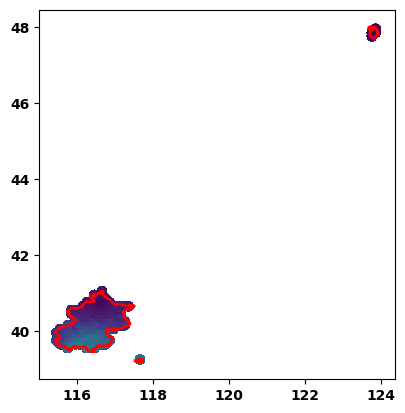

CURRENT LOCATION:  Islamabad


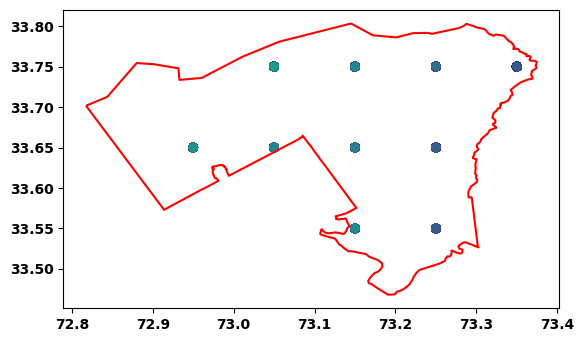

In [75]:
combined_df = gpd.GeoDataFrame()

for location, location_gdf in tqdm(locations.items()):
    print("CURRENT LOCATION: ", location)

    cords = location_gdf.bounds.values
    # print("BOUNDING CORDS: ", cords)
    lat1 = cords[0][1]
    lat2 = cords[0][3]
    lon1 = cords[0][0]
    lon2 = cords[0][2]
    
    
    local_df = df[(df.Latitude >= lat1) & (df.Latitude <= lat2) & (df.Longitude >= lon1) & \
                (df.Longitude <= lon2)].reset_index(drop = True)
    local_df['geometry'] = gpd.points_from_xy(local_df['Longitude'], local_df['Latitude'])
    local_df = local_df.set_geometry('geometry')
    local_df = gpd.sjoin(local_df, location_gdf, predicate = 'within').reset_index(drop = True)
    local_df = local_df[local_df.OMI_NO2 > 0]
    local_df = local_df[['Latitude','Longitude','OMI_NO2',	'Date', 'geometry']]
    local_df['City'] = location

    combined_df = pd.concat([combined_df, local_df])
    ax = plt.subplot()
    location_gdf.geometry.boundary.plot(ax = ax, color = 'red')
    local_df.plot(column = "OMI_NO2", ax = ax )
    plt.show()

In [76]:
combined_df.rename(columns = {'Date': 'Date0'}, inplace = True)

In [77]:
del df

In [78]:
combined_df['Date'] = combined_df['Date0'].apply(lambda x : x[:4]+"-"+x[4:])
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Year'] = combined_df.Date.dt.year
combined_df['Month'] = combined_df.Date.dt.month
combined_df['Date1'] = combined_df['Date'].apply(lambda x : x.to_period(freq = 'M'))

In [79]:
combined_df[['Date0', 'Date', 'Date1', 'Year', 'Month']].sample(5)

,Date0,Date,Date1,Year,Month
865,201203,2012-03-01,2012-03,2012,3
1677,200510,2005-10-01,2005-10,2005,10
4686,200703,2007-03-01,2007-03,2007,3
34394,202102,2021-02-01,2021-02,2021,2
24533,201607,2016-07-01,2016-07,2016,7


In [80]:
date_range = pd.date_range('2005-01-01', '2022-12-31', freq = 'M')
date_range = [i.to_period(freq = "M") for i in date_range]

# Timeseries Year-Month Variation

In [81]:
for city in combined_df.City.unique():
    local_df = combined_df[combined_df.City == city].reset_index(drop = True)
    local_df = local_df.groupby('Date1')['OMI_NO2'].mean()
    print("EACH CITY MUST HAVE 216 values")
    print("City \""+city+"\" has {} values".format(local_df.shape[0]))
    print("\n")

EACH CITY MUST HAVE 216 values
City "New Delhi" has 216 values


EACH CITY MUST HAVE 216 values
City "Kathmandu" has 206 values


EACH CITY MUST HAVE 216 values
City "Dhaka" has 216 values


EACH CITY MUST HAVE 216 values
City "Beijing" has 216 values


EACH CITY MUST HAVE 216 values
City "Islamabad" has 216 values




In [82]:
def add_null_values_to_missing_dates(df_local):
    df_local = df_local.copy()
    dates_in_df = df_local.Date1.values
    new_data_to_add = []

    for i in date_range:
        temp = []
        if i not in dates_in_df:
            temp.append(i)
            temp.append(np.nan)
            new_data_to_add.append(temp)


    arr = np.append(df_local.values, new_data_to_add, axis = 0)
    arr = pd.DataFrame(arr, columns = df_local.columns)
    arr = arr.sort_values('Date1', ascending = True)
    arr = arr.reset_index(drop = True)
    
    return arr   

In [83]:
combined_df.City.unique()

array(['New Delhi', 'Kathmandu', 'Dhaka', 'Beijing', 'Islamabad'],
      dtype=object)

In [84]:
# color_and_markers_for_cities = {
#     'Thimpu': ['red', 'o'],
#     'Mumbai': ['blue', 's'],
#     'Islamabad' : ['green', '^'],
#     'Singapore': ['black', 'o']
# }

In [85]:
from matplotlib import rc, rcParams
rc('font', weight='normal')
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) 
from matplotlib import ticker
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,0)) 

In [86]:
combined_df.City.unique()

array(['New Delhi', 'Kathmandu', 'Dhaka', 'Beijing', 'Islamabad'],
      dtype=object)

In [87]:
combined_df.City.unique()

array(['New Delhi', 'Kathmandu', 'Dhaka', 'Beijing', 'Islamabad'],
      dtype=object)

In [88]:
combined_df1 = combined_df.copy()

In [89]:
combined_df1

,Latitude,Longitude,OMI_NO2,Date0,geometry,City,Date,Year,Month,Date1
0,28.549999,77.150009,1.063977e+16,200501,POINT (77.15001 28.55000),New Delhi,2005-01-01,2005,1,2005-01
1,28.549999,77.150009,8.514030e+15,200502,POINT (77.15001 28.55000),New Delhi,2005-02-01,2005,2,2005-02
2,28.549999,77.150009,6.179123e+15,200503,POINT (77.15001 28.55000),New Delhi,2005-03-01,2005,3,2005-03
3,28.549999,77.150009,7.631625e+15,200504,POINT (77.15001 28.55000),New Delhi,2005-04-01,2005,4,2005-04
4,28.549999,77.150009,6.842756e+15,200505,POINT (77.15001 28.55000),New Delhi,2005-05-01,2005,5,2005-05
...,...,...,...,...,...,...,...,...,...,...
2155,33.649998,73.250000,4.553628e+15,202212,POINT (73.25000 33.65000),Islamabad,2022-12-01,2022,12,2022-12
2156,33.750004,73.050003,7.010100e+15,202212,POINT (73.05000 33.75000),Islamabad,2022-12-01,2022,12,2022-12
2157,33.750004,73.150009,6.095180e+15,202212,POINT (73.15001 33.75000),Islamabad,2022-12-01,2022,12,2022-12
2158,33.750004,73.250000,5.066001e+15,202212,POINT (73.25000 33.75000),Islamabad,2022-12-01,2022,12,2022-12


In [90]:
avg_df = combined_df1.groupby(['Date1', 'City']).agg({'OMI_NO2':['mean']}).reset_index()
avg_df.columns = ['Date1', 'City', 'Mean']
avg_df['Date2'] = avg_df['Date1'].apply(lambda x : x.to_timestamp())

In [91]:
avg_df.City.unique()

array(['Beijing', 'Dhaka', 'Islamabad', 'Kathmandu', 'New Delhi'],
      dtype=object)

In [92]:
markers_dict = {"Beijing":"o",
               'Dhaka':'s',
               'Islamabad': 'd',
               'Kathmandu': '^',
               'New Delhi': 'v'}

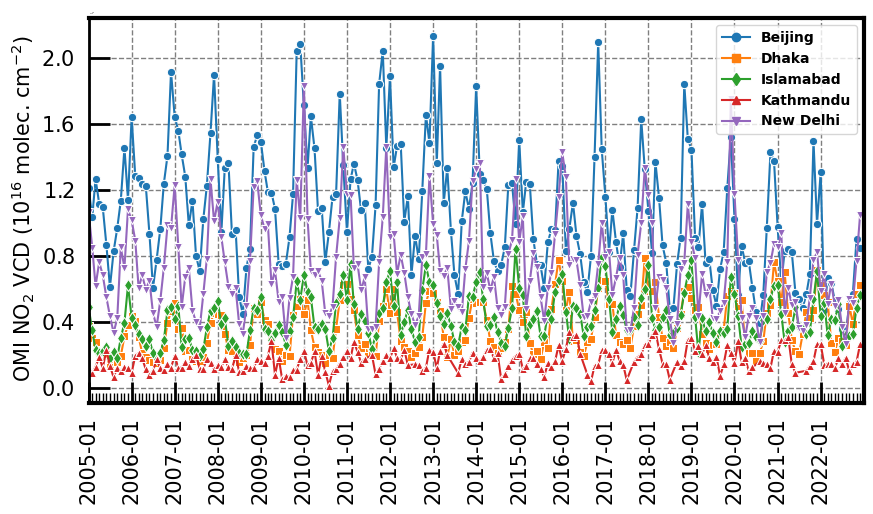

In [95]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

ax1 = plt.subplot(1, 1, 1)

plot = sns.lineplot(x = 'Date2', y = 'Mean', hue = 'City', data = avg_df, markers = markers_dict, style = 'City', ax= ax1,\
                   dashes = False)
plot.set_ylabel("")
plot.set_xlabel("")

legend = plt.legend()
for text in legend.get_texts():
    text.set_fontweight('bold')


ax1.yaxis.set_major_locator(plt.MaxNLocator(6))
ax1.yaxis.set_tick_params(labelsize=15, pad = 10)
ax1.xaxis.set_tick_params(labelsize=15, pad = 10)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax1.set_xlim([pd.to_datetime('2005-01-01'), pd.to_datetime('2022-12-31')])
plt.xticks(rotation = 'vertical');

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,0)) 
ax1.yaxis.set_major_formatter(formatter)
ax1.ticklabel_format(style='scientific', axis = 'y') 
t = ax1.yaxis.get_offset_text()
t.set_size(0) 


ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['right'].set_linewidth(3)
ax1.spines['top'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_lw(2)
ax1.tick_params(which='minor', width=1)
ax1.tick_params(which='major', width=2)
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=7)
ax1.tick_params(which = 'both', direction = 'in')
ax1.grid(True, axis = 'both',which = 'major', alpha = .5, linestyle='--', linewidth = 1, color = 'black')

# fig.text(0.5, 0.025, 'Date', ha='center', va='center', fontsize = 15)
# ($10^{15}$ 
fig.text(0.06, 0.5, 'OMI NO$_2$ VCD ($10^{16}$ molec. $\mathregular{cm^{-2}}$)', ha='center', \
         va='center', rotation='vertical', fontsize = 15)
plt.savefig('NEW_SouthAsian_Cities_YearMonth.jpg',  bbox_inches='tight', dpi = 500)

# Yearly Variation

In [96]:
for city in combined_df.City.unique():
    local_df = combined_df[combined_df.City == city].reset_index(drop = True)
    local_df = local_df.groupby('Year')['OMI_NO2'].mean()
    print("EACH CITY MUST HAVE 18 values")
    print("City \""+city+"\" has {} values".format(local_df.shape[0]))
    print("\n")

EACH CITY MUST HAVE 18 values
City "New Delhi" has 18 values


EACH CITY MUST HAVE 18 values
City "Kathmandu" has 18 values


EACH CITY MUST HAVE 18 values
City "Dhaka" has 18 values


EACH CITY MUST HAVE 18 values
City "Beijing" has 18 values


EACH CITY MUST HAVE 18 values
City "Islamabad" has 18 values




In [97]:
avg_df = combined_df.groupby(['Year', 'City']).agg({'OMI_NO2':['mean']}).reset_index()
avg_df.columns = ['Year', 'City', 'Mean']
avg_df

,Year,City,Mean
0,2005,Beijing,1.061090e+16
1,2005,Dhaka,2.458978e+15
2,2005,Islamabad,3.044058e+15
3,2005,Kathmandu,1.303024e+15
4,2005,New Delhi,6.988472e+15
...,...,...,...
85,2022,Beijing,6.336658e+15
86,2022,Dhaka,4.274764e+15
87,2022,Islamabad,4.063196e+15
88,2022,Kathmandu,1.698023e+15


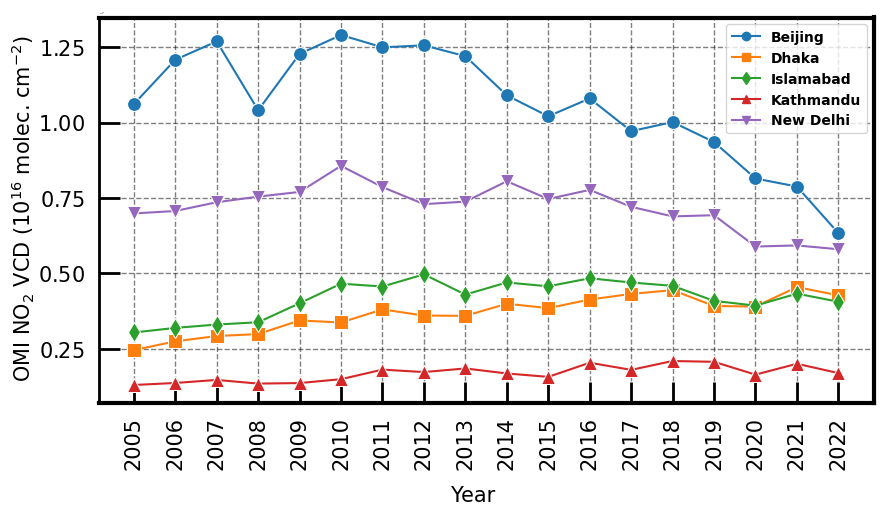

In [99]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

ax1 = plt.subplot(1, 1, 1)

plot = sns.lineplot(x = 'Year', y = 'Mean', hue = 'City', data = avg_df,
                    markers = markers_dict, style = 'City', markersize  = 10,
                   dashes = False)
plot.set_ylabel("")
plot.set_xlabel("")

# Access legend and set font weight to bold
legend = plt.legend()
for text in legend.get_texts():
    text.set_fontweight('bold')

ax1.yaxis.set_major_locator(plt.MaxNLocator(6))
ax1.yaxis.set_tick_params(labelsize=15, pad = 10)
ax1.xaxis.set_tick_params(labelsize=15, pad = 10)
plt.xticks(range(2005, 2023, 1))
plt.xticks(rotation = 'vertical');

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,0)) 
ax1.yaxis.set_major_formatter(formatter)
ax1.ticklabel_format(style='scientific', axis = 'y') 
t = ax1.yaxis.get_offset_text()
t.set_size(0) 


ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['right'].set_linewidth(3)
ax1.spines['top'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_lw(2)
ax1.tick_params(which='minor', width=1)
ax1.tick_params(which='major', width=2)
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=7)
ax1.tick_params(which = 'both', direction = 'in')
ax1.grid(True, axis = 'both',which = 'major', alpha = .5, linestyle='--', linewidth = 1, color = 'black')

fig.text(0.5, -0.075, 'Year', ha='center', va='center', fontsize = 15)
fig.text(0.05, 0.5, 'OMI NO$_2$ VCD ($10^{16}$ molec. $\mathregular{cm^{-2}}$)', ha='center', \
         va='center', rotation='vertical', fontsize = 15)

plt.savefig('Year_SouthAsian_Cities_Year.jpg',  bbox_inches='tight', dpi = 500)

# Monthly Variation

In [100]:
Months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', "D"]

In [101]:
avg_df = combined_df.groupby(['Month', 'City']).agg({'OMI_NO2':['mean']}).reset_index()
avg_df.columns = ['Month', 'City', 'Mean']
avg_df.head()

,Month,City,Mean
0,1,Beijing,1.429607e+16
1,1,Dhaka,5.369482e+15
2,1,Islamabad,5.996408e+15
3,1,Kathmandu,1.965464e+15
4,1,New Delhi,1.083528e+16


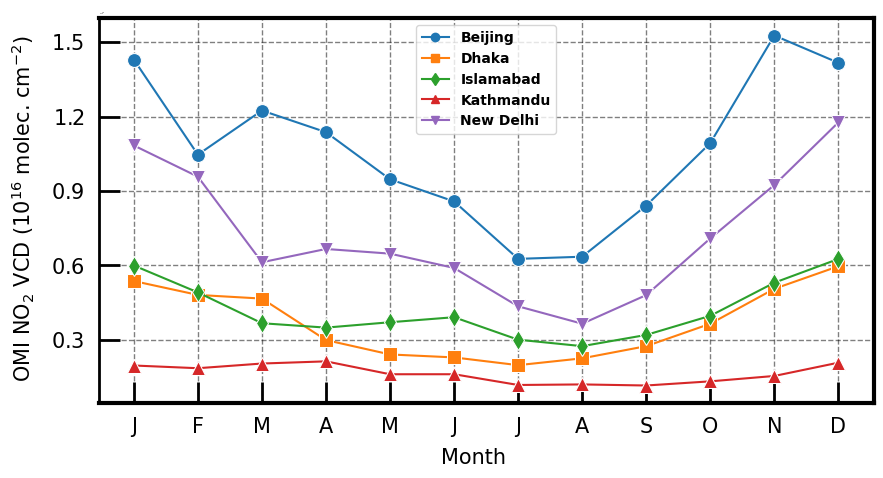

In [103]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

ax1 = plt.subplot(1, 1, 1)

plot = sns.lineplot(x = 'Month', y = 'Mean', hue = 'City', data = avg_df,
                    markers = markers_dict, style = 'City', markersize  = 10,
                   dashes = False)
plot.set_ylabel("")
plot.set_xlabel("")

# Access legend and set font weight to bold
legend = plt.legend()
for text in legend.get_texts():
    text.set_fontweight('bold')

ax1.yaxis.set_major_locator(plt.MaxNLocator(6))
ax1.yaxis.set_tick_params(labelsize=15, pad = 10)
ax1.xaxis.set_tick_params(labelsize=15, pad = 10)
plt.xticks(range(1, 13, 1))
plt.xticks(ax1.get_xticks(), Months, fontsize =15)
plt.xticks(rotation = 'horizontal');

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,0)) 
ax1.yaxis.set_major_formatter(formatter)
ax1.ticklabel_format(style='scientific', axis = 'y') 
t = ax1.yaxis.get_offset_text()
t.set_size(0) 


ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['right'].set_linewidth(3)
ax1.spines['top'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_lw(2)
ax1.tick_params(which='minor', width=1)
ax1.tick_params(which='major', width=2)
ax1.tick_params(which='major', length=15)
ax1.tick_params(which='minor', length=7)
ax1.tick_params(which = 'both', direction = 'in')
ax1.grid(True, axis = 'both',which = 'major', alpha = .5, linestyle='--', linewidth = 1, color = 'black')

fig.text(0.5, 0, 'Month', ha='center', va='center', fontsize = 15)
fig.text(0.05, 0.5, 'OMI NO$_2$ VCD ($10^{16}$ molec. $\mathregular{cm^{-2}}$)', ha='center', \
         va='center', rotation='vertical', fontsize = 15)

plt.savefig('NEW_SouthAsian_Cities_Month.jpg',  bbox_inches='tight', dpi = 500)

# Seasonal Variation

In [104]:
months_and_seasons = {
        'Dec-Jan-Feb': [12, 1, 2],
        'Mar-Apr-May': [3, 4, 5],
        'Jun-Jul-Aug': [6, 7, 8],
        'Sep-Oct-Nov': [9, 10, 11]
}
def return_season_for_a_month(m):
    for key, val in months_and_seasons.items():
        if m in val:
            return key

In [105]:
combined_df_backup = combined_df.copy()

In [106]:
%%time

combined_df['Season'] = combined_df.Month.apply(lambda x : return_season_for_a_month(x))

CPU times: total: 15.6 ms
Wall time: 38.7 ms


In [107]:
combined_df.groupby('Season')['Month'].unique()

Season
Dec-Jan-Feb     [1, 2, 12]
Jun-Jul-Aug      [6, 7, 8]
Mar-Apr-May      [3, 4, 5]
Sep-Oct-Nov    [9, 10, 11]
Name: Month, dtype: object

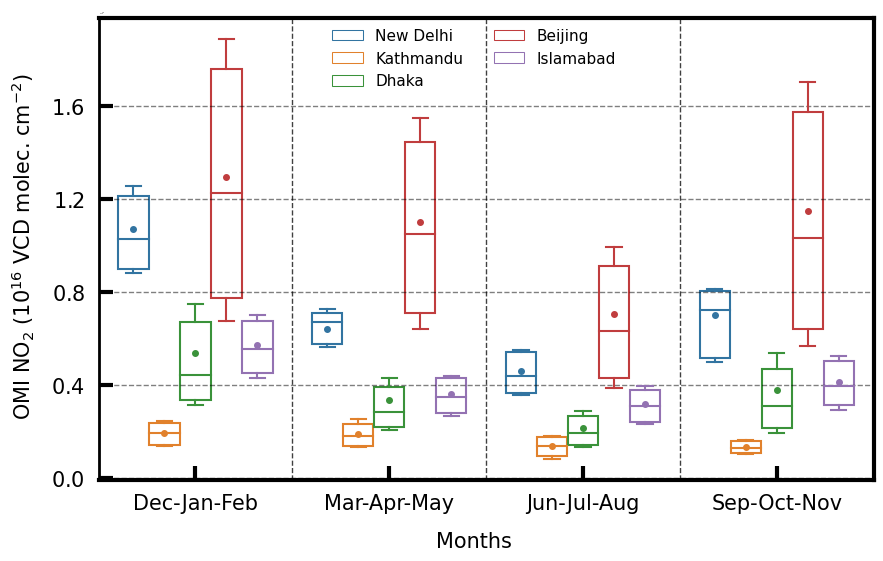

In [109]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

ax1 = plt.subplot(1,1,1)
sns.boxplot(x = 'Season', y ='OMI_NO2', hue = 'City', data = combined_df, showmeans = True,showfliers = False, \
            ax = ax1, whis = [20, 80],\
            meanprops = {'marker':'o', 'markersize':4})
ax1.set_xlabel('')
ax1.set_ylabel('')


box_patches = [patch for patch in ax1.patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
    box_patches = ax1.artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax1.lines) // num_patches
for i, patch in enumerate(box_patches):

    # Set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')


    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax1.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

# # Also fix the legend
for legpatch in ax1.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')    
    
    
ax1.yaxis.set_major_locator(plt.MaxNLocator(6))
ax1.yaxis.set_tick_params(labelsize=15, pad = 10)
ax1.xaxis.set_tick_params(labelsize=15, pad = 10)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,0)) 
ax1.yaxis.set_major_formatter(formatter)
ax1.ticklabel_format(style='scientific', axis = 'y') 
t = ax1.yaxis.get_offset_text()
t.set_size(0) 


ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['right'].set_linewidth(3)
ax1.spines['top'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_lw(2)
ax1.tick_params(which='minor', width=1)
ax1.tick_params(which='major', width=3)
ax1.tick_params(which='major', length=10)
ax1.tick_params(which='minor', length=12)
ax1.tick_params(which = 'both', direction = 'in')
ax1.grid(True, axis = 'y',which = 'major', alpha = .5, linestyle='--', linewidth = 1, color = 'black')
# add a vertical line after the second boxplot
ax1.axvline(0.5, color='black', linewidth=1, alpha = 0.75,linestyle = '--')
ax1.axvline(1.5, color='black', linewidth=1, alpha = 0.75,linestyle = '--')
ax1.axvline(2.5, color='black', linewidth=1, alpha = 0.75,linestyle = '--')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
markers = ax1.get_legend().get_patches()
leg = fig.legend(markers, labels, loc="upper left", bbox_to_anchor=(0.345, 0.885), \
                         fontsize=11, ncol=2, markerscale=5, frameon=False)





ax1.get_legend().remove()
fig.text(0.5, 0.0075, 'Months', ha='center', va='center', fontsize = 15)
fig.text(0.05, 0.5, 'OMI NO$_2$ ($10^{16}$ VCD molec. $\mathregular{cm^{-2}}$)', ha='center', \
         va='center', rotation='vertical', fontsize = 15)


plt.savefig('Season_SouthAsian_Cities.jpg',  bbox_inches='tight', dpi = 500)